In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import pandas as pd
from tensorflow import keras as k
from keras.utils import np_utils
import cv2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense

In [2]:
X=[]
y=[]

# Since there are subfolders inside the input directory, we've used nested loops
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        path=os.path.join(dirname, filename) 
        
# Preprocessing the image:
# - read image
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# - Adaptive Threshold: For every pixel, the same threshold value is applied. If the pixel value
# is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value
# It removes the greyish tinge off the image.
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
  
# - Closing: It is useful in closing small holes inside the foreground objects, 
# or small black points on the object
        kernel = np.ones((5,5),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        
# - Dilation: So it increases the white region in the image or 
# size of foreground object increases
        kernel = np.ones((2,2),np.uint8)
        image = cv2.dilate(image, kernel, iterations = 1)
 
# - Blur: As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc.
# LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.
        image = cv2.GaussianBlur(image, (5,5), 0)
 

# Splitting up the image into sections of each character
        x=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

# Labelling segments with the image name
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i])))
            y.append(path[len(path)-9:len(path)-4][i])
X=np.array(X)
y=np.array(y)

In [3]:
X=X.astype('float32')
X/=255

y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

In [4]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 5, 16)        0         
 2D)                                                    

In [5]:
batch_size = 150
epochs = 200

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

Epoch 1/200
29/29 [==============================] - 2s 49ms/step - loss: 2.9041 - accuracy: 0.0937 - val_loss: 2.7700 - val_accuracy: 0.1084
Epoch 2/200
29/29 [==============================] - 1s 42ms/step - loss: 2.2807 - accuracy: 0.2904 - val_loss: 1.8102 - val_accuracy: 0.4701
Epoch 3/200
29/29 [==============================] - 2s 53ms/step - loss: 1.6727 - accuracy: 0.5033 - val_loss: 1.3714 - val_accuracy: 0.6346
Epoch 4/200
29/29 [==============================] - 1s 45ms/step - loss: 1.3983 - accuracy: 0.5942 - val_loss: 1.1297 - val_accuracy: 0.6813
Epoch 5/200
29/29 [==============================] - 2s 54ms/step - loss: 1.2039 - accuracy: 0.6540 - val_loss: 0.9983 - val_accuracy: 0.7364
Epoch 6/200
29/29 [==============================] - 2s 52ms/step - loss: 1.0888 - accuracy: 0.6820 - val_loss: 0.9097 - val_accuracy: 0.7523
Epoch 7/200
29/29 [==============================] - 1s 46ms/step - loss: 1.0153 - accuracy: 0.7037 - val_loss: 0.8403 - val_accuracy: 0.7738
Epoch 

29/29 [==============================] - 1s 44ms/step - loss: 0.1840 - accuracy: 0.9360 - val_loss: 0.5353 - val_accuracy: 0.8804
Epoch 116/200
29/29 [==============================] - 1s 43ms/step - loss: 0.1840 - accuracy: 0.9325 - val_loss: 0.5532 - val_accuracy: 0.8879
Epoch 117/200
29/29 [==============================] - 1s 44ms/step - loss: 0.1924 - accuracy: 0.9311 - val_loss: 0.5481 - val_accuracy: 0.8804
Epoch 118/200
29/29 [==============================] - 1s 44ms/step - loss: 0.1889 - accuracy: 0.9269 - val_loss: 0.5651 - val_accuracy: 0.8813
Epoch 119/200
29/29 [==============================] - 1s 44ms/step - loss: 0.1805 - accuracy: 0.9336 - val_loss: 0.5633 - val_accuracy: 0.8925
Epoch 120/200
29/29 [==============================] - 1s 43ms/step - loss: 0.1956 - accuracy: 0.9322 - val_loss: 0.5499 - val_accuracy: 0.8869
Epoch 121/200
29/29 [==============================] - 1s 41ms/step - loss: 0.1878 - accuracy: 0.9318 - val_loss: 0.5925 - val_accuracy: 0.8888
Epoch 

Epoch 172/200
29/29 [==============================] - 2s 53ms/step - loss: 0.1389 - accuracy: 0.9477 - val_loss: 0.5896 - val_accuracy: 0.8972
Epoch 173/200
29/29 [==============================] - 2s 53ms/step - loss: 0.1278 - accuracy: 0.9519 - val_loss: 0.5861 - val_accuracy: 0.8972
Epoch 174/200
29/29 [==============================] - 2s 56ms/step - loss: 0.1457 - accuracy: 0.9442 - val_loss: 0.5656 - val_accuracy: 0.8860
Epoch 175/200
29/29 [==============================] - 2s 55ms/step - loss: 0.1437 - accuracy: 0.9481 - val_loss: 0.6031 - val_accuracy: 0.8841
Epoch 176/200
29/29 [==============================] - 2s 56ms/step - loss: 0.1516 - accuracy: 0.9453 - val_loss: 0.5922 - val_accuracy: 0.8869
Epoch 177/200
29/29 [==============================] - 2s 56ms/step - loss: 0.1464 - accuracy: 0.9451 - val_loss: 0.5999 - val_accuracy: 0.8991
Epoch 178/200
29/29 [==============================] - 2s 56ms/step - loss: 0.1469 - accuracy: 0.9491 - val_loss: 0.5673 - val_accuracy:

In [6]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

34/34 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.8953
Test loss: 0.5959094762802124
Test accuracy: 0.895327091217041


In [7]:
model.save('captcha_reader.h5')

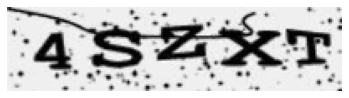

1/1 [==============================] - 0s 90ms/step
Prediction: 38c37

In [8]:
from tensorflow.keras.models import load_model
saved_model = load_model('captcha_reader.h5')

def pred (img_path) :
    
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(im,(200,50), interpolation = cv2.INTER_CUBIC)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = saved_model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
img_p='img-cap.jpg'
pred(img_p)

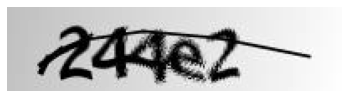

1/1 [==============================] - 0s 19ms/step
Prediction: 244e2

In [10]:
img_p='244e2.png'
pred(img_p)